In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#모델 생성

In [ ]:
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 


In [ ]:
#파일 지정, 초기값 설정 
class Config():
    training_dir = "/content/drive/MyDrive/Colab Notebooks/인공지능 기초/train"
    testing_dir = "/content/drive/MyDrive/Colab Notebooks/인공지능 기초/test"
    train_batch_size = 32
    train_number_epochs = 10

In [ ]:
training_dir="/content/drive/MyDrive/Colab Notebooks/인공지능 기초/train"
training_csv="/content/drive/MyDrive/Colab Notebooks/인공지능 기초/train_data.csv"
testing_csv="/content/drive/MyDrive/Colab Notebooks/인공지능 기초/test_data.csv"
testing_dir="/content/drive/MyDrive/Colab Notebooks/인공지능 기초/test"

In [ ]:
# 이미지 시각화를 위한 함수 선언
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

In [ ]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # 이미지, 라벨을 매칭
          self.training_df=pd.read_csv(training_csv)
          self.training_df.columns =["image1","image2","label"]
          self.training_dir = training_dir    
          self.transform = transform

    def __getitem__(self,index):
        
        # 이미지 저장 경로 
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        
        
        # 이미지 로드
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # 이미지 transform
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [ ]:
# 이미지 파일을 샴네트웨크에 맞게 조정한 데이터 셋
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,transform=transforms.Compose([transforms.Resize((105,105)),transforms.ToTensor()]))


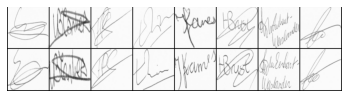

[[1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]


In [ ]:
# 샘플 체크 & 라벨링 확인
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter) #data중 하나 샘플로 값 뽑아오기
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
# model network 만들기
class SiameseNetwork(nn.Module): 
    def __init__(self):
        super(SiameseNetwork, self).__init__() #nn.module에 상속 받아 정의 및 초기화
        
        # cnn layer 구성
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),

        )
        
        # fc layer 구성
        self.fc1 = nn.Sequential(
            
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2)) # 자기자신 or 위조
        
  
  
    def forward_once(self, x):
        # 모델 순전파 방향 흐름
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2): #유사도 비교를 위한 입력2 출력2
        # 순전파 인풋1:아웃풋1
        output1 = self.forward_once(input1)
        # 순전파 인풋2:아웃풋2
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):#손실함수 정의

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__() #부모 클래스 상속을 위한 초기화
        self.margin = margin

    def forward(self, output1, output2, label): #순전파 방향의 output으로 손실을 정의, contrastive loss를 손실함수로 사용
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,shuffle=True,num_workers=2,batch_size=Config.train_batch_size)

In [ ]:
# 샴네트워크모델 선언
net = SiameseNetwork().cuda()
# 손실함수 선언
criterion = ContrastiveLoss()
# 옵티마이저 선언
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.0001)

In [ ]:
#모델 정확도 측정 함수
def getAccuracy():
  net.eval()
  list_0 = torch.FloatTensor([[0]])
  list_1 = torch.FloatTensor([[1]])
  acc = 0
  total = 0
  with torch.no_grad():
    for data in train_dataloader:
      image1,image2, label = data
      output1, output2 = net(image1,image2)
      eucledian_distance = F.pairwise_distance(output1, output2)
      if eucledian_distance.item() <= 0.8 and label == list_0: #상이도 0.8이하이고 라벨이 0인경우(본인)
        acc += 1
      elif eucledian_distance.item() > 0.8 and label == list_1: #상이도 0.8이상이고 라벨이 1인경우(위조)
        acc += 1
      
      total += 1

  accuracy = (100 * acc / total)
  return (accuracy)
         
      

In [ ]:
#훈련 함수 정의
def train():
  best_accuracy = 0.0

  for epoch in range(0,Config.train_number_epochs): 
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_dataloader,0): #인덱스, 데이터 저장
      img0, img1 , label = data
      img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
      optimizer.zero_grad() #옵티마이저 파라미터 0으로 초기화
      output1,output2 = net(img0,img1) #샴네트워크 모델 순전파 결과
      loss_contrastive = criterion(output1,output2,label) #손실 측정
      loss_contrastive.backward() #손실함수의 오차역전파(nn.module에서 제공)
      optimizer.step()
      running_loss += loss_contrastive.item()     # extract the loss value
      if i %50 == 49 :
        print("Epoch:{} loss:{:0.2f}\n".format(epoch,loss_contrastive.item()))
        running_loss = 0.0

    accuracy = getAccuracy()
    print('epoch', epoch+1,'일 때 accuracy:%d %%' %(accuracy))
    
    if accuracy > best_accuracy:
      torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/인공지능 기초/model_adam.pt")
      best_accuracy = accuracy

In [ ]:
#cuda 사용확인
'''
if torch.cuda.is_available():
  print('Yes')
'''

In [ ]:
train()
print("학습완료")

KeyboardInterrupt: ignored

#모델 불러오기

In [ ]:
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 

In [ ]:
#모델 저장
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/인공지능 기초/model_adam.pt")

In [ ]:
#모델 불러오기
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/인공지능 기초/model_adam.pt"))
model.eval()

In [ ]:
# 저장된 모델 로드
model = SiameseNetwork()
# 저장된 모델 파라미터 공유
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/인공지능 기초/model_adam.pt")) 

<All keys matched successfully>

In [ ]:
# 테스트 데이터 셋 로드
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,transform=transforms.Compose([transforms.Resize((105,105)),transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


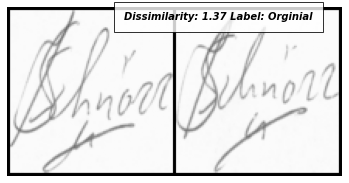

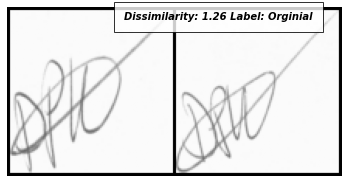

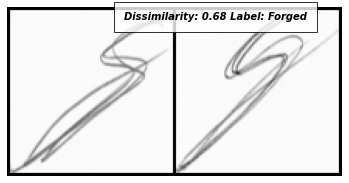

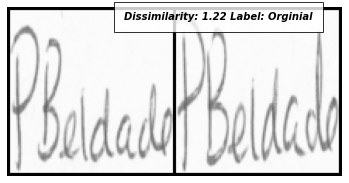

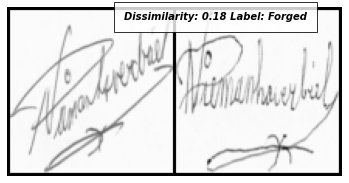

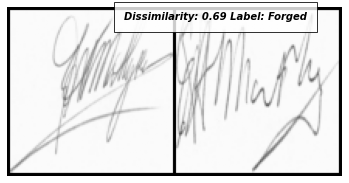

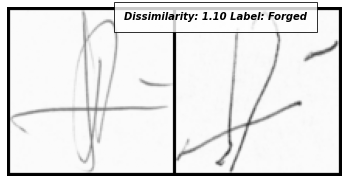

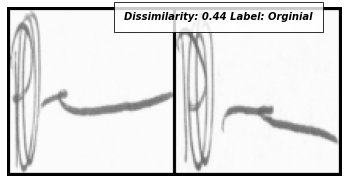

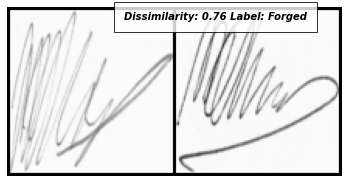

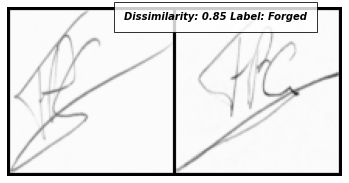

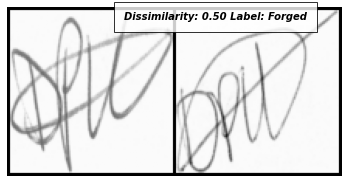

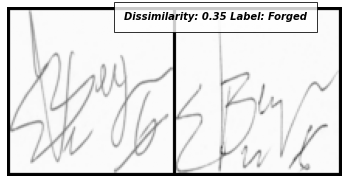

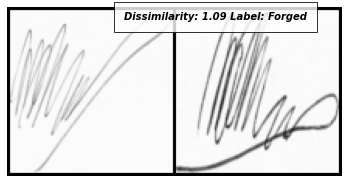

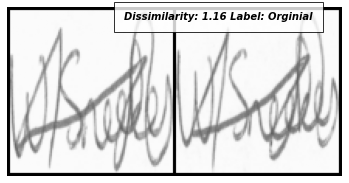

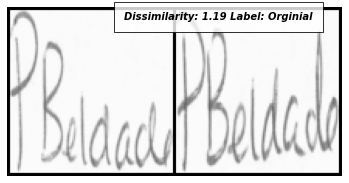

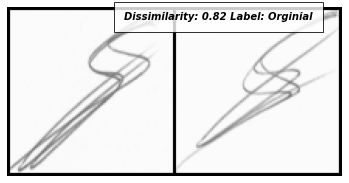

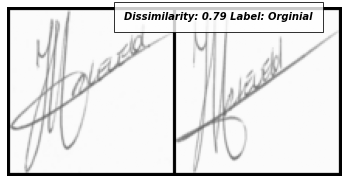

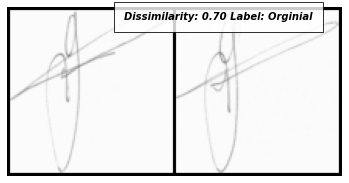

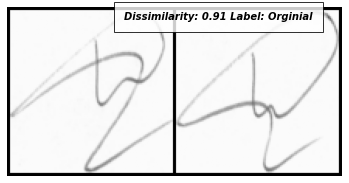

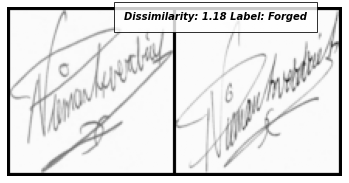

In [ ]:
# 각 이미지별 dissimilarity 비교.
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = model(x0,x1)
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter == 10:
     break